# Training

## Setup

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import pandas as pd
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
#from torch.autograd import Variable

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
#torch.backends.cudnn.enabled = False
val_size = 5000
test_size = 5000
batch_size = 16
num_workers = 4

transform = transforms.Compose([transforms.ToTensor()])

# Downloading MNIST again :) Training (60k) and test(5k) + val(5k) split
train_loader = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data',
                                            download=True,
                                            train=True,
                                            transform=transform),
                                            batch_size=batch_size,
                                            shuffle=True, num_workers=num_workers)

test_dataset = datasets.MNIST('./mnist_data',
                               download=True,
                               train=False,
                               transform=transform)

val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size])

# Test set to compare with DDPM paper
test_loader = torch.utils.data.DataLoader(test_dataset,
                                            batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers)

# Validation set so we can keep track of approximated FID score while training
validation_loader = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=16,
                                            shuffle=False, num_workers=num_workers)
    

In [3]:
# Sets up alpha_bar for training and test so alpha_bar_t = alpha_bar[t]
T = 1000
beta_start, beta_end = [1e-4, 2e-02]
beta = torch.linspace(beta_start, beta_end, T)
alpha = 1-beta
alpha_bar = alpha.clone()
for e in range(T-1):
    alpha_bar[e+1] *= alpha_bar[e]

alpha = alpha.view((1000, 1, 1, 1)).to(device)
beta = beta.view((1000, 1, 1, 1)).to(device)
alpha_bar = alpha_bar.view((1000, 1, 1, 1)).to(device)

## Model

In [4]:
class UNET(torch.nn.Module):
    def __init__(self):
        super(UNET, self).__init__()
        channels = [32, 64, 128, 256]
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(2, channels[0], kernel_size=3, padding=1),  # (batchsize, 32, 28, 28)
                nn.ReLU(),
            ),
            nn.Sequential(
                nn.MaxPool2d(2),  # (batchsize, 32, 14, 14)
                nn.Conv2d(channels[0], channels[1], kernel_size=3, padding=1),  # (batchsize, 64, 14, 14)
                nn.ReLU(),
            ),
            nn.Sequential(
                nn.MaxPool2d(2),  # (batchsize, 64, 7, 7)
                nn.Conv2d(channels[1], channels[2], kernel_size=3, padding=1),  # (batchsize, 128, 7, 7)
                nn.ReLU(),
            ),
            nn.Sequential(
                nn.MaxPool2d(2, padding=1),  # (batchsize, 128, 4, 4)
                nn.Conv2d(channels[2], channels[3], kernel_size=3, padding=1),  # (batchsize, 256, 4, 4)
                nn.ReLU(),
            )
        ])

        self.tconvs = nn.ModuleList([
            nn.Sequential(
                nn.ConvTranspose2d(channels[3], channels[2], kernel_size=3, 
                                   stride=2, padding=1, output_padding=0),   # (batchsize, 128, 7, 7)
                nn.ReLU()
            ),
            nn.Sequential(
                nn.ConvTranspose2d(channels[2]*2, channels[1], kernel_size=3,
                                   stride=2, padding=1, output_padding=1),   # (batchsize, 64, 14, 14)
                nn.ReLU()
            ),
            nn.Sequential(
                nn.ConvTranspose2d(channels[1]*2, channels[0], kernel_size=3, 
                                   stride=2, padding=1, output_padding=1),   # (batchsize, 32, 28, 28)
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Conv2d(channels[0]*2,channels[0],kernel_size=3,padding=1),  # (batchsize, 32, 28, 28)
                nn.ReLU(),
                nn.Conv2d(channels[0],1,kernel_size=1) # (batchsize, 1, 28, 28)
            )      
        ])

    def forward(self, x, t):
        x_trans = torch.cat((x, t), dim=-3)
        signal = x_trans
        signals = []

        for i, conv in enumerate(self.convs):
            # print(f"conv {i}")
            signal = conv(signal)
            # print(signal.shape)
            if i < len(conv):
                signals.append(signal)
        
        for i, tconv in enumerate(self.tconvs):
            # print(f"tconv {i}")
            # print(f"signal shape: {signal.shape}")
            if i == 0:
                signal = tconv(signal)
            else:
                signal = torch.cat((signal, signals[-i]), dim=-3)
                signal = tconv(signal)
        return signal

## Training loop

In [7]:
#from UNET import UNET
epochs = 10
model = UNET()
model.to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss(reduction="sum")
running_loss = 0

In [8]:
for epoch in range(epochs):
    for e, data in enumerate(train_loader):
        x0, _ = data
        x0 = x0.to(device)
        t = torch.randint(1, T+1, (batch_size,)).to(device)
        eps = torch.randn(batch_size, 1, 28, 28).to(device)
        # print(eps.shape)
        # print(x0.shape)
        loss = criterion(eps, model(torch.sqrt(alpha_bar[t-1]) * x0 + 
                                    torch.sqrt(1 - alpha_bar[t-1]) * eps, t.view(batch_size, 1, 1, 1).expand(batch_size, 1, 28, 28)))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        if e % 100 == 99:
            print(f'{epoch, e+1}, loss: {running_loss:.3f}')
            running_loss = 0.0
        
    if epoch % 5 == 4:
        torch.save(model.state_dict(), f"DDPM_{epoch}.pth")

(0, 100), loss: 78578336.253
(0, 200), loss: 1145486.697
(0, 300), loss: 1053935.149
(0, 400), loss: 971328.878
(0, 500), loss: 890939.700
(0, 600), loss: 808739.320
(0, 700), loss: 739154.519
(0, 800), loss: 674102.320
(0, 900), loss: 604442.711
(0, 1000), loss: 551610.452
(0, 1100), loss: 499652.636
(0, 1200), loss: 452129.303
(0, 1300), loss: 393777.650
(0, 1400), loss: 375523.385
(0, 1500), loss: 336397.442
(0, 1600), loss: 288248.737
(0, 1700), loss: 268627.358
(0, 1800), loss: 253391.202
(0, 1900), loss: 251286.664
(0, 2000), loss: 226346.861
(0, 2100), loss: 216790.087
(0, 2200), loss: 206215.364
(0, 2300), loss: 198554.569
(0, 2400), loss: 205182.737
(0, 2500), loss: 206298.417
(0, 2600), loss: 185512.696
(0, 2700), loss: 185430.950
(0, 2800), loss: 214630.608
(0, 2900), loss: 10130534.897
(0, 3000), loss: 354766.156
(0, 3100), loss: 215164.619
(0, 3200), loss: 195457.508
(0, 3300), loss: 194991.698
(0, 3400), loss: 181711.698
(0, 3500), loss: 185008.519
(0, 3600), loss: 187319

KeyboardInterrupt: 

# Sampling

In [9]:
import matplotlib.pyplot as plt
model.eval()

UNET(
  (convs): ModuleList(
    (0): Sequential(
      (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (1): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU()
    )
    (2): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU()
    )
    (3): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
      (1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU()
    )
  )
  (tconvs): ModuleList(
    (0): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 64, kerne

In [11]:
batch_size = 1
xt = torch.randn(batch_size, 1, 28, 28).to(device)

for t in torch.arange(T, 0, -1):
    print(t)
    t = t.to(device)
    z = torch.randn(batch_size, 1, 28, 28).to(device) if t > 1 else torch.zeros(batch_size, 1, 28, 28).to(device)
    xt_new = 1 / torch.sqrt(alpha[t - 1]) * (xt - (1 - alpha[t - 1])/(torch.sqrt(1 - alpha_bar[t - 1])) * 
                                                   model(xt, t.view(batch_size, 1, 1, 1).expand(batch_size, 1, 28, 28))) + torch.sqrt(beta[t-1]) * z
    xt = xt_new
    

tensor(1000)
tensor(999)
tensor(998)
tensor(997)
tensor(996)
tensor(995)
tensor(994)
tensor(993)
tensor(992)
tensor(991)
tensor(990)
tensor(989)
tensor(988)
tensor(987)
tensor(986)
tensor(985)
tensor(984)
tensor(983)
tensor(982)
tensor(981)
tensor(980)
tensor(979)
tensor(978)
tensor(977)
tensor(976)
tensor(975)
tensor(974)
tensor(973)
tensor(972)
tensor(971)
tensor(970)
tensor(969)
tensor(968)
tensor(967)
tensor(966)
tensor(965)
tensor(964)
tensor(963)
tensor(962)
tensor(961)
tensor(960)
tensor(959)
tensor(958)
tensor(957)
tensor(956)
tensor(955)
tensor(954)
tensor(953)
tensor(952)
tensor(951)
tensor(950)
tensor(949)
tensor(948)
tensor(947)
tensor(946)
tensor(945)
tensor(944)
tensor(943)
tensor(942)
tensor(941)
tensor(940)
tensor(939)
tensor(938)
tensor(937)
tensor(936)
tensor(935)
tensor(934)
tensor(933)
tensor(932)
tensor(931)
tensor(930)
tensor(929)
tensor(928)
tensor(927)
tensor(926)
tensor(925)
tensor(924)
tensor(923)
tensor(922)
tensor(921)
tensor(920)
tensor(919)
tensor(918)
ten

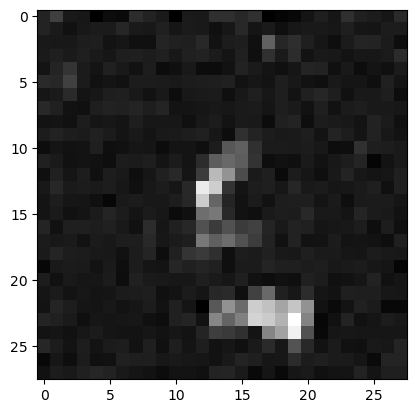

In [18]:
plt.imshow(xt[0][0].cpu().detach().numpy(), cmap="grey")